=== FINAL MODEL WITH STATISTICAL TESTS ===
Data shape: (5630, 39)
Training set: (4504, 37)
Test set: (1126, 37)

1. LOADING BEST MODELS
✓ Baseline model loaded
✓ Advanced model loaded

2. FINAL MODEL COMPARISON

--- Evaluating Random Forest ---
Accuracy: 0.9822
AUC: 0.9982
F1-Score: 0.9451
Precision: 0.9885
Recall: 0.9053

--- Evaluating LGBMClassifier ---
Accuracy: 0.9938
AUC: 0.9989
F1-Score: 0.9814
Precision: 0.9893
Recall: 0.9737

3. STATISTICAL SIGNIFICANCE TESTS
Bootstrap Analysis (95% Confidence Intervals):

AUC:
  Random Forest: 0.9982 [0.9968, 0.9993]
  LGBMClassifier: 0.9989 [0.9973, 1.0000]

Accuracy:
  Random Forest: 0.9820 [0.9742, 0.9893]
  LGBMClassifier: 0.9938 [0.9893, 0.9982]

F1:
  Random Forest: 0.9444 [0.9180, 0.9670]
  LGBMClassifier: 0.9815 [0.9668, 0.9942]

------------------------------
McNemar's Test for Model Comparison:
------------------------------
Contingency Table:
  Both correct: 1105
  Random Forest correct only: 1
  LGBMClassifier correct only: 14
  B

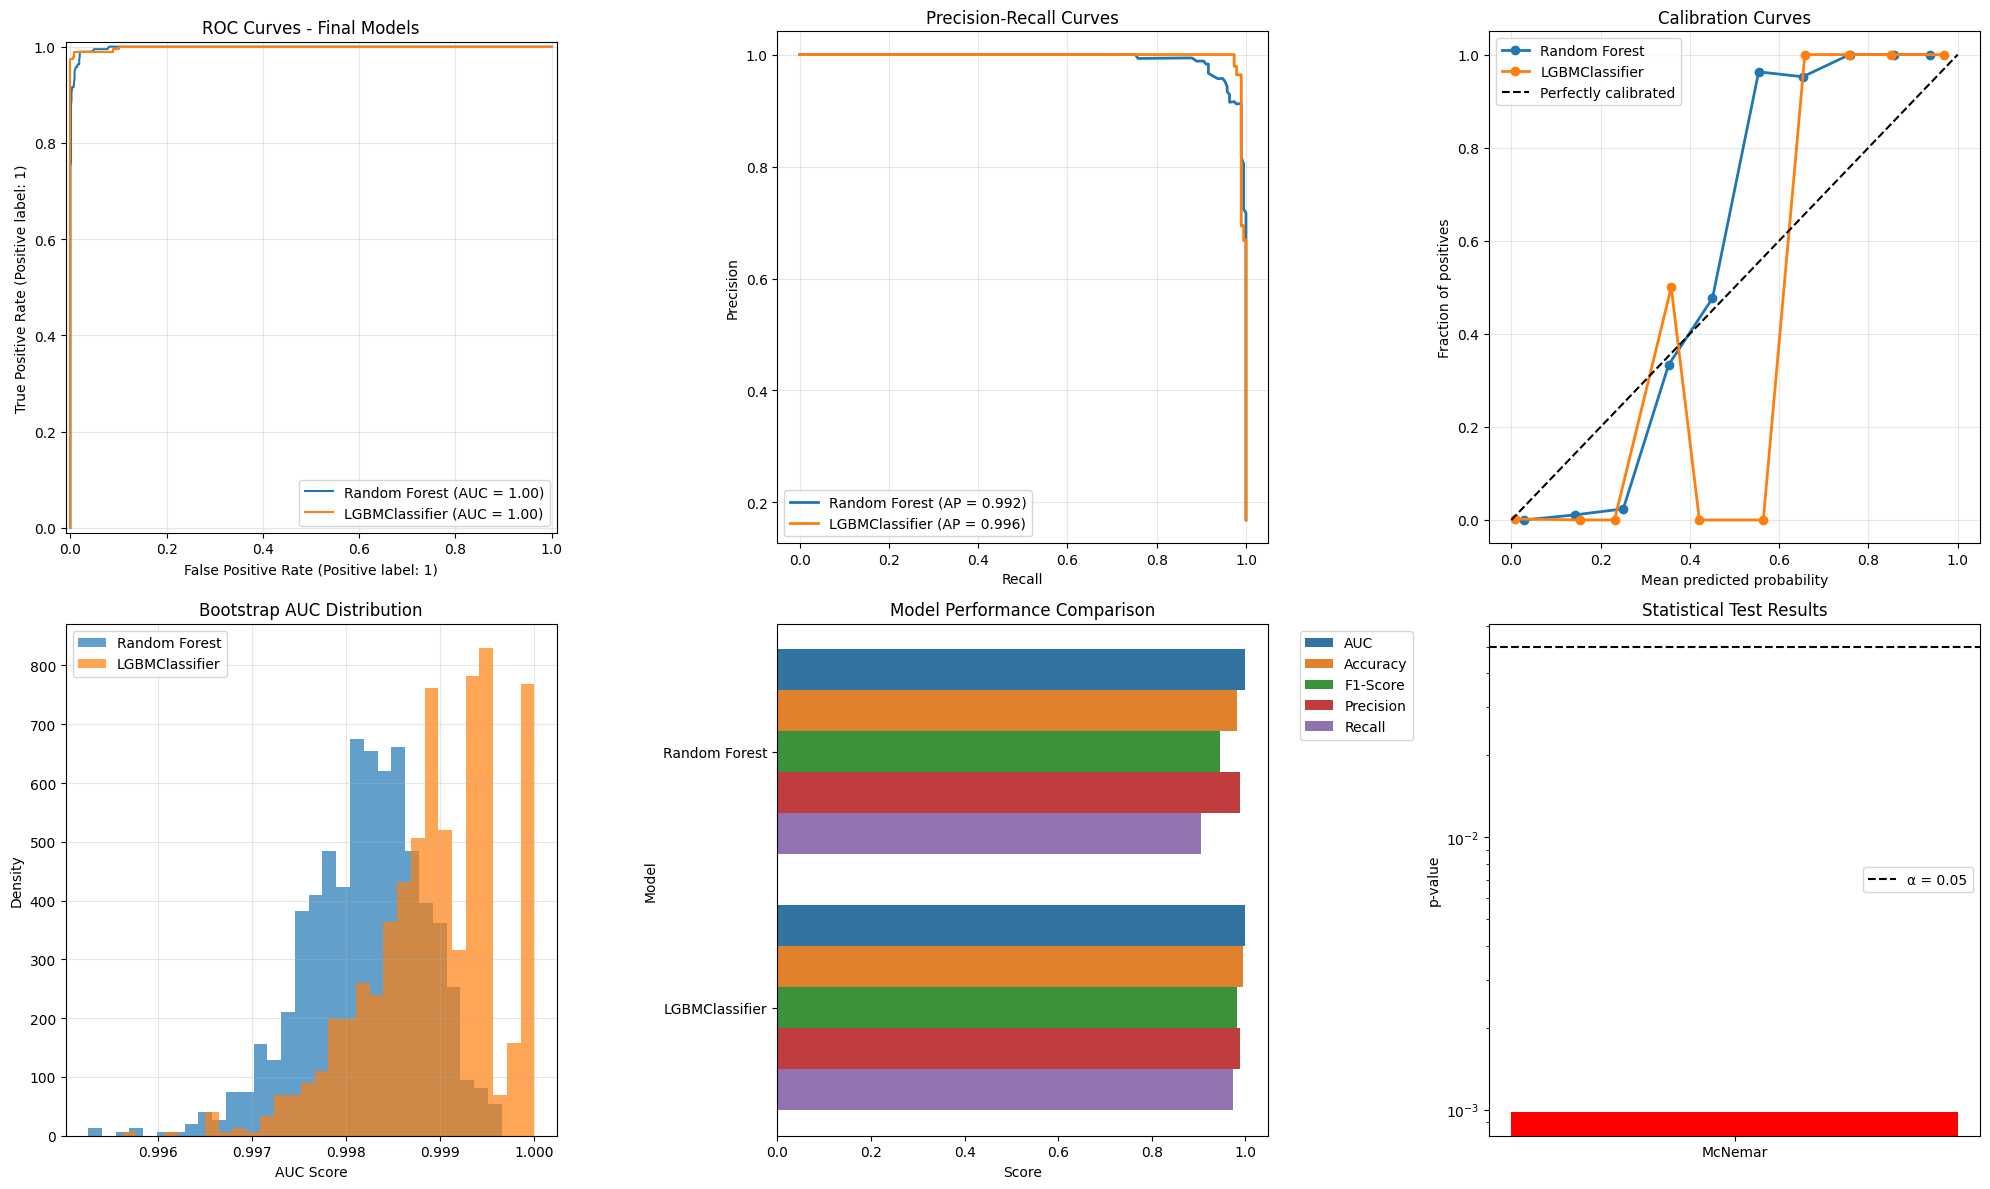


5. BUSINESS IMPACT ANALYSIS
Business Impact Analysis (Assumptions):
  - Average Customer Value: $1,000
  - Retention Cost per Customer: $200
  - Retention Success Rate: 30%

Business Impact for LGBMClassifier:
  False Negative Cost: $1,500.00
  False Positive Cost: $400.00
  True Positive Net Value: $18,500.00
  Total Net Value: $16,600.00
  Value Per Customer: $14.74
  Retention Roi: $0.48

Confusion Matrix:
  True Negatives: 934
  False Positives: 2
  False Negatives: 5
  True Positives: 185

6. FINAL MODEL SELECTION
🎯 SELECTED FINAL MODEL: LGBMClassifier
📊 Final Performance:
   - AUC: 0.9989
   - Accuracy: 0.9938
   - F1-Score: 0.9814
   - Business Value: $16,600.00
📈 AUC 95% Confidence Interval: [0.9973, 1.0000]

7. SAVING FINAL ARTIFACTS
{'model_name': 'Customer_Churn_Predictor', 'model_type': 'LGBMClassifier', 'model_version': '1.0', 'training_date': '2025-12-03T18:36:38.454647', 'performance': {'test_auc': 0.9989035087719299, 'test_accuracy': 0.9937833037300178, 'test_f1': 0.98

In [ ]:
# Final Model with Statistical Tests and Business Impact
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           precision_recall_curve, average_precision_score, RocCurveDisplay)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import VotingClassifier
from scipy import stats
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
from src.config.database import get_connection_string

print("=== FINAL MODEL WITH STATISTICAL TESTS ===")

# Load data
engine = create_engine(get_connection_string())
query = "SELECT * FROM ml_ready_features"
df = pd.read_sql(query, engine)

print(f"Data shape: {df.shape}")

# Prepare data
X = df.drop(['Churn', 'CustomerID'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print("\n" + "="*50)
print("1. LOADING BEST MODELS")
print("="*50)

import joblib

try:
    # Load baseline model
    baseline_model = joblib.load('../models/baseline/best_baseline_model.pkl')
    print("✓ Baseline model loaded")
    
    # Load advanced model
    advanced_model = joblib.load('../models/advanced/best_advanced_model.pkl')
    print("✓ Advanced model loaded")
    
    # Get model names (you might need to adjust this based on your actual models)
    baseline_name = "Random Forest"  # Adjust based on your best baseline
    advanced_name = type(advanced_model).__name__
    
except FileNotFoundError:
    print("❌ Pre-trained models not found. Please run previous notebooks first.")
    raise

print("\n" + "="*50)
print("2. FINAL MODEL COMPARISON")
print("="*50)

final_models = {
    baseline_name: baseline_model,
    advanced_name: advanced_model
}

final_results = {}

for name, model in final_models.items():
    print(f"\n--- Evaluating {name} ---")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = model.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Additional metrics
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Store results
    final_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'avg_precision': avg_precision,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

print("\n" + "="*50)
print("3. STATISTICAL SIGNIFICANCE TESTS")
print("="*50)

def bootstrap_metric(y_true, y_pred_proba, metric_func, n_bootstrap=1000, random_state=42):
    """Bootstrap confidence intervals for any metric"""
    np.random.seed(random_state)
    n_samples = len(y_true)
    scores = []
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        score = metric_func(y_true.iloc[indices], y_pred_proba[indices])
        scores.append(score)
    
    return np.array(scores)

print("Bootstrap Analysis (95% Confidence Intervals):")

bootstrap_results = {}
metrics_to_bootstrap = {
    'AUC': roc_auc_score,
    'Accuracy': lambda y_true, y_pred_proba: np.mean((y_pred_proba > 0.5) == y_true),
    'F1': lambda y_true, y_pred_proba: f1_score(y_true, (y_pred_proba > 0.5).astype(int))
}

for metric_name, metric_func in metrics_to_bootstrap.items():
    print(f"\n{metric_name}:")
    for model_name, results in final_results.items():
        scores = bootstrap_metric(y_test, results['probabilities'], metric_func)
        ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
        mean_score = np.mean(scores)
        bootstrap_results[f"{model_name}_{metric_name}"] = scores
        
        print(f"  {model_name}: {mean_score:.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

print("\n" + "-"*30)
print("McNemar's Test for Model Comparison:")
print("-"*30)

from statsmodels.stats.contingency_tables import mcnemar

def create_contingency_table(y_true, pred1, pred2):
    """Create contingency table for McNemar's test"""
    both_correct = np.sum((y_true == pred1) & (y_true == pred2))
    both_wrong = np.sum((y_true != pred1) & (y_true != pred2))
    model1_correct = np.sum((y_true == pred1) & (y_true != pred2))
    model2_correct = np.sum((y_true != pred1) & (y_true == pred2))
    
    table = [[both_correct, model1_correct],
             [model2_correct, both_wrong]]
    return table

model_names = list(final_results.keys())
if len(model_names) >= 2:
    pred1 = final_results[model_names[0]]['predictions']
    pred2 = final_results[model_names[1]]['predictions']
    
    contingency_table = create_contingency_table(y_test, pred1, pred2)
    result = mcnemar(contingency_table, exact=True)
    
    print(f"Contingency Table:")
    print(f"  Both correct: {contingency_table[0][0]}")
    print(f"  {model_names[0]} correct only: {contingency_table[0][1]}")
    print(f"  {model_names[1]} correct only: {contingency_table[1][0]}")
    print(f"  Both wrong: {contingency_table[1][1]}")
    print(f"McNemar's test p-value: {result.pvalue:.4f}")
    
    if result.pvalue < 0.05:
        print("→ Statistically significant difference in model performance")
    else:
        print("→ No statistically significant difference")

print("\n" + "-"*30)
print("ROC AUC Statistical Comparison:")
print("-"*30)

# Implementation of DeLong test for ROC AUC comparison
def delong_test(y_true, probas1, probas2):
    """DeLong test for comparing two ROC curves"""
    from scipy import stats
    
    # Calculate AUC variances using DeLong method
    n = len(y_true)
    n1 = np.sum(y_true == 1)
    n0 = n - n1
    
    # Helper functions for DeLong variance
    def calculate_v10_v01(y_true, probas):
        positives = probas[y_true == 1]
        negatives = probas[y_true == 0]
        
        v10 = np.array([np.mean(negatives < pos) for pos in positives])
        v01 = np.array([np.mean(positives > neg) for neg in negatives])
        
        return v10, v01
    
    v10_1, v01_1 = calculate_v10_v01(y_true, probas1)
    v10_2, v01_2 = calculate_v10_v01(y_true, probas2)
    
    # Calculate covariance
    S = np.cov(np.concatenate([v10_1 - v10_2, v01_1 - v01_2]))
    if S.size == 1:
        S = S.reshape(1, 1)
    
    # Calculate test statistic
    auc1 = roc_auc_score(y_true, probas1)
    auc2 = roc_auc_score(y_true, probas2)
    L = np.array([1, -1]).reshape(1, -1)
    
    try:
        z = (auc1 - auc2) / np.sqrt(np.dot(np.dot(L, S), L.T) * (1/n1 + 1/n0))
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z)))
    except:
        z = 0
        p_value = 1
    
    return z, p_value

if len(model_names) >= 2:
    probas1 = final_results[model_names[0]]['probabilities']
    probas2 = final_results[model_names[1]]['probabilities']
    
    z_score, p_value = delong_test(y_test, probas1, probas2)
    print(f"DeLong test z-score: {z_score:.4f}")
    print(f"DeLong test p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("→ Statistically significant difference in ROC AUC")
    else:
        print("→ No statistically significant difference in ROC AUC")

print("\n" + "="*50)
print("4. COMPREHENSIVE MODEL EVALUATION")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# ROC Curves
for name, results in final_results.items():
    RocCurveDisplay.from_predictions(
        y_test, results['probabilities'], 
        name=name, ax=axes[0,0]
    )
axes[0,0].set_title('ROC Curves - Final Models')
axes[0,0].grid(True, alpha=0.3)

# Precision-Recall Curves
for name, results in final_results.items():
    precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
    axes[0,1].plot(recall, precision, label=f'{name} (AP = {results["avg_precision"]:.3f})', linewidth=2)
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curves')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Calibration Curves
for name, results in final_results.items():
    prob_true, prob_pred = calibration_curve(y_test, results['probabilities'], n_bins=10)
    axes[0,2].plot(prob_pred, prob_true, marker='o', label=name, linewidth=2)
axes[0,2].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
axes[0,2].set_xlabel('Mean predicted probability')
axes[0,2].set_ylabel('Fraction of positives')
axes[0,2].set_title('Calibration Curves')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Bootstrap Distribution Comparison
metric_to_plot = 'AUC'
if len(model_names) >= 2:
    scores1 = bootstrap_results[f"{model_names[0]}_{metric_to_plot}"]
    scores2 = bootstrap_results[f"{model_names[1]}_{metric_to_plot}"]
    
    axes[1,0].hist(scores1, bins=30, alpha=0.7, label=model_names[0], density=True)
    axes[1,0].hist(scores2, bins=30, alpha=0.7, label=model_names[1], density=True)
    axes[1,0].set_xlabel(f'{metric_to_plot} Score')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title(f'Bootstrap {metric_to_plot} Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# Metric Comparison
metrics_comparison = []
for name, results in final_results.items():
    metrics_comparison.append({
        'Model': name,
        'AUC': results['auc'],
        'Accuracy': results['accuracy'],
        'F1-Score': results['f1'],
        'Precision': results['precision'],
        'Recall': results['recall']
    })

metrics_df = pd.DataFrame(metrics_comparison)
metrics_melted = metrics_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

sns.barplot(data=metrics_melted, x='Score', y='Model', hue='Metric', ax=axes[1,1])
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Statistical Significance Visualization
if len(model_names) >= 2:
    p_values = [result.pvalue]  # McNemar's p-value
    tests = ['McNemar']
    
    axes[1,2].bar(tests, p_values, color=['red' if p < 0.05 else 'blue' for p in p_values])
    axes[1,2].axhline(y=0.05, color='black', linestyle='--', label='α = 0.05')
    axes[1,2].set_ylabel('p-value')
    axes[1,2].set_title('Statistical Test Results')
    axes[1,2].set_yscale('log')
    axes[1,2].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("5. BUSINESS IMPACT ANALYSIS")
print("="*50)

def calculate_business_impact(y_true, y_pred_proba, threshold=0.5, 
                            avg_customer_value=1000, retention_cost=200, 
                            retention_success_rate=0.3):
    """
    Calculate business impact of churn prediction model
    """
    y_pred = (y_pred_proba > threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Business calculations
    total_customers = len(y_true)
    actual_churners = y_true.sum()
    
    # Costs and revenues
    customer_lifetime_value = avg_customer_value
    
    # Cost of false negatives (missed churners we could have retained)
    fn_cost = fn * customer_lifetime_value * retention_success_rate
    
    # Cost of false positives (unnecessary retention efforts)
    fp_cost = fp * retention_cost
    
    # Value from true positives (successful retentions)
    tp_value = tp * customer_lifetime_value * retention_success_rate
    tp_cost = tp * retention_cost
    tp_net_value = tp_value - tp_cost
    
    # Total impact
    total_net_value = tp_net_value - fn_cost - fp_cost
    value_per_customer = total_net_value / total_customers
    
    return {
        'confusion_matrix': {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp},
        'false_negative_cost': fn_cost,
        'false_positive_cost': fp_cost,
        'true_positive_net_value': tp_net_value,
        'total_net_value': total_net_value,
        'value_per_customer': value_per_customer,
        'retention_roi': (tp_net_value - fp_cost) / (tp_cost + fp_cost) if (tp_cost + fp_cost) > 0 else 0
    }

print("Business Impact Analysis (Assumptions):")
print("  - Average Customer Value: $1,000")
print("  - Retention Cost per Customer: $200")
print("  - Retention Success Rate: 30%")
print()

best_model_name = max(final_results.items(), key=lambda x: x[1]['auc'])[0]
best_proba = final_results[best_model_name]['probabilities']

business_impact = calculate_business_impact(y_test, best_proba)

print(f"Business Impact for {best_model_name}:")
for metric, value in business_impact.items():
    if metric != 'confusion_matrix':
        print(f"  {metric.replace('_', ' ').title()}: ${value:,.2f}")

print(f"\nConfusion Matrix:")
cm = business_impact['confusion_matrix']
print(f"  True Negatives: {cm['TN']}")
print(f"  False Positives: {cm['FP']}")
print(f"  False Negatives: {cm['FN']}")
print(f"  True Positives: {cm['TP']}")

print("\n" + "="*50)
print("6. FINAL MODEL SELECTION")
print("="*50)

# Select best model based on comprehensive evaluation
best_final_model_name = max(final_results.items(), key=lambda x: x[1]['auc'])[0]
best_final_model = final_results[best_final_model_name]['model']

print(f"🎯 SELECTED FINAL MODEL: {best_final_model_name}")
print(f"📊 Final Performance:")
print(f"   - AUC: {final_results[best_final_model_name]['auc']:.4f}")
print(f"   - Accuracy: {final_results[best_final_model_name]['accuracy']:.4f}")
print(f"   - F1-Score: {final_results[best_final_model_name]['f1']:.4f}")
print(f"   - Business Value: ${business_impact['total_net_value']:,.2f}")

# Statistical confidence for final model
final_auc_scores = bootstrap_metric(y_test, final_results[best_final_model_name]['probabilities'], roc_auc_score)
final_auc_ci = np.percentile(final_auc_scores, [2.5, 97.5])
print(f"📈 AUC 95% Confidence Interval: [{final_auc_ci[0]:.4f}, {final_auc_ci[1]:.4f}]")

print("\n" + "="*50)
print("7. SAVING FINAL ARTIFACTS")
print("="*50)

import json
from datetime import datetime

# Save final model
joblib.dump(best_final_model, '../models/final/churn_model.pkl')

# Save feature names
feature_names = list(X.columns)
joblib.dump(feature_names, '../models/final/feature_names.pkl')

# Create model card
model_card = {
    'model_name': 'Предсказатель оттока клиентов',
    'model_type': type(best_final_model).__name__,
    'model_version': '1.0',
    'training_date': datetime.now().isoformat(),
    'performance': {
        'test_auc': float(final_results[best_final_model_name]['auc']),
        'test_accuracy': float(final_results[best_final_model_name]['accuracy']),
        'test_f1': float(final_results[best_final_model_name]['f1']),
        'auc_confidence_interval': [float(final_auc_ci[0]), float(final_auc_ci[1])]
    },
    'statistical_tests': {
        'mcnemar_pvalue': float(result.pvalue) if len(model_names) >= 2 else None,
        'delong_pvalue': float(p_value) if len(model_names) >= 2 else None
    },
    'business_impact': {k: float(v) if isinstance(v, (int, float)) else v 
                       for k, v in business_impact.items()},
    'feature_count': len(feature_names),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

print(model_card)

print("✓ Final model saved")
print("✓ Feature names saved")
print("✓ Model card saved")

print("\n✅ FINAL MODEL EVALUATION COMPLETED!")
print(f"\nSummary for {best_final_model_name}:")
print(f"🎯 AUC: {final_results[best_final_model_name]['auc']:.4f}")
print(f"📊 Accuracy: {final_results[best_final_model_name]['accuracy']:.4f}")
print(f"💰 Business Value: ${business_impact['total_net_value']:,.2f}")
print(f"📈 Statistical Confidence: 95% AUC CI [{final_auc_ci[0]:.4f}, {final_auc_ci[1]:.4f}]")

print("\nThe model is ready for deployment! 🚀")